In [1]:
import os
os.chdir("../results")

In [2]:
%pwd

'/home/kosa/src/scheduling-algorithm/results'

In [3]:
import sqlite3

In [4]:
# Load the results database
conn = sqlite3.connect('./results.db')
c = conn.cursor()

In [63]:
def getValue(vals, model, i):
    try:
        return str(vals[model][i])
    except Exception as e:
        print(vals[model], i, e)
        return "0"
    
def getDicValue(dic, i):
    try:
        return str(dic[i])
    except Exception as e:
        print(dic, i, e)
        return "0"

# Generate workflows

```bash
parallel --ungroup -j1 'sage ../script/gen.sage workflows 30 --nbWorkflow {1} --maxSize {2}' ::: 20 40 80 100 120 1 :::+ 700 1500 3200 3700 4700 5400
```

# Running experiments

```bash
PYTHONPATH=$PWD/../python_2phases/ parallel --col-sep="\|" --dryrun -j2 python3 ../python_2phases/experiments/main_exp_all.py -p instances/{1}.inst -c 4 -n 0.5 ::: $(for nbTask in 20 40 80 100 120 140; do sqlite3 results.db "SELECT instanceInfo.instance FROM instanceInfo LEFT JOIN makespan ON instanceInfo.instance=makespan.instance AND algo LIKE '2P' AND nbCPU = 4 AND networkFactor = 0.5 WHERE makespan IS NULL AND instanceInfo.instance LIKE 'workflows\_${nbTask}%' ESCAPE '\';"; done)
parallel --colsep="\|" --bar -j4 ../bui/SchedulingDCN {1} -c 4 -n 0.5 -m {2} ::: $(for model in "listScheduling" "listSchedulingMaster" "listNoCapacity"; do for size in 20 40 80 100 120 140; do sqlite3 results.db "SELECT instanceInfo.instance,'$model' FROM instanceInfo LEFT JOIN makespan ON instanceInfo.instance=makespan.instance AND nbCPU = 4 AND algo LIKE '$model' AND networkFactor = 0.5 AND nbCPU = 4 WHERE makespan IS NULL AND instanceInfo.instance LIKE 'workflows\_$size%' ESCAPE '\';"; done; done)
```

# All in

```bash
(parallel --ungroup -j1 'sage ../script/gen.sage workflows 30 --nbWorkflow {1} --maxSize {2}' ::: 20 40 80 100 120 1 :::+ 700 1500 3200 3700 4700 5400) && (python ../script/saveResults.py) && (PYTHONPATH=$PWD/../python_2phases/ parallel --col-sep="\|" --dryrun -j2 python3 ../python_2phases/experiments/main_exp_all.py -p instances/{1}.inst -c 4 -n 0.5 ::: $(for nbTask in 20 40 80 100 120 140; do sqlite3 results.db "SELECT instanceInfo.instance FROM instanceInfo LEFT JOIN makespan ON instanceInfo.instance=makespan.instance AND algo LIKE '2P' AND nbCPU = 4 AND networkFactor = 0.5 WHERE makespan IS NULL AND instanceInfo.instance LIKE 'workflows\_${nbTask}%' ESCAPE '\';"; done)) && (parallel --colsep="\|" --bar -j4 ../bui/SchedulingDCN {1} -c 4 -n 0.5 -m {2} ::: $(for model in "listScheduling" "listSchedulingMaster" "listNoCapacity"; do for size in 20 40 80 100 120 140; do sqlite3 results.db "SELECT instanceInfo.instance,'$model' FROM instanceInfo LEFT JOIN makespan ON instanceInfo.instance=makespan.instance AND nbCPU = 4 AND algo LIKE '$model' AND networkFactor = 0.5 AND nbCPU = 4 WHERE makespan IS NULL AND instanceInfo.instance LIKE 'workflows\_$size%' ESCAPE '\';"; done; done))
```

# Get workflows and the number of results done for all \# CPUs

```
sqlite3 results.db "SELECT mk.instance, count(*) as nbDone FROM instanceInfo as info INNER JOIN makespan as mk ON mk.instance = info.instance WHERE mk.networkFactor = 0.5 AND mk.instance LIKE 'workflows\_20\_%' ESCAPE '\' GROUP BY mk.instance ORDER BY nbDone";
```

In [31]:
%run ../script/plots.py

ALL_DONE_WORKFLOWS = "IN ('workflows_20_google_google_1531950079', 'workflows_20_google_google_1531950080', 'workflows_20_google_google_1532023072', 'workflows_20_google_google_1532023073', 'workflows_20_google_google_1532023074', 'workflows_20_google_google_1532023075', 'workflows_20_google_google_1532553962', 'workflows_20_google_google_1564516472', 'workflows_20_google_google_1564516473', 'workflows_20_google_google_1564516475', 'workflows_20_google_google_1564516476', 'workflows_20_google_google_1564516477', 'workflows_20_google_google_1564516478', 'workflows_20_google_google_1564516479') "
Part_NOT_BAD_WORKFLOWS = "IN ('workflows_20_google_google_1531950079', 'workflows_20_google_google_1532023072', 'workflows_20_google_google_1532023073', 'workflows_20_google_google_1532023074', 'workflows_20_google_google_1532023075', 'workflows_20_google_google_1532553962', 'workflows_20_google_google_1564516475', 'workflows_20_google_google_1564516477', 'workflows_20_google_google_1564516478', 'workflows_20_google_google_1564516479') "
for instance in ["LIKE 'K1_100_%'", "LIKE 'K2_%_100_%'", "LIKE 'random_%_100_%'", Part_NOT_BAD_WORKFLOWS]:
    xVals, yVals = get(conn, info="avg(makespan/max(lp, (sumCPU/nbCPU)))", group=("nbCPU", "nbCPU"), instanceName=instance, setParams=" AND networkFactor=0.5", models=Scheduling.MODELS)

    print("\t".join(["nbCPU"]+Scheduling.MODELS))
    Xs = xVals[Scheduling.MODELS[0]]
    for i in range(len(Xs)):
        print("\t".join([str(Xs[i])] + [getValue(yVals, model, i) for model in Scheduling.MODELS]))

SELECT algo, nbCPU, avg(makespan/max(lp, (sumCPU/nbCPU))) FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance LIKE 'K1_100_%'  AND networkFactor=0.5 AND algo IN ("listScheduling", "listSchedulingMaster", "2P", "listNoCapacity") GROUP BY algo, nbCPU
nbCPU	listScheduling	listSchedulingMaster	2P	listNoCapacity
1.0	1.0	1.0	1.0	1.0
2.0	1.2988714743759415	1.2976263572880267	1.5002793077956973	4.873993212064337
3.0	1.7475956399182093	1.7439139022396053	2.2504189616935473	9.0632688938545
4.0	2.2271465247282483	2.222866597353305	2.720776950470304	13.286469850836049
5.0	2.723181144156195	2.7172270823070646	3.3994660174512368	17.607117022253664
10.0	5.2716900766443935	5.259958931211491	6.60598087175005	39.05755843932671
SELECT algo, nbCPU, avg(makespan/max(lp, (sumCPU/nbCPU))) FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance LIKE 'K2_%_100_%'  AND networkFactor=0.5 AND algo IN ("listSchedu

In [127]:
%run ../script/plots.py

reqAllWorkflowDone = "SELECT instance FROM makespan WHERE nbCPU = 4 AND algo IN ('2P', 'listScheduling', 'listSchedulingMaster', 'listNoCapacity') AND instance LIKE 'workflows\_%' ESCAPE '\\' GROUP BY instance HAVING  count(*) = 4*8"

for instance in ["LIKE 'K1_100_%'", "LIKE 'K2_%_100_%'", "LIKE 'random_%_100_%'", 'IN ({}) '.format(reqAllWorkflowDone)]:
    xVals, yVals = get(conn, info="avg(makespan/max(lp, (sumCPU/nbCPU)))", group=("networkFactor", "networkFactor"), instanceName=instance, setParams=" AND nbCPU=4", models=Scheduling.MODELS)

    print("\t".join(["networkFactor"]+Scheduling.MODELS))
    Xs = xVals[Scheduling.MODELS[0]]
    for i in range(len(Xs)):
        print("\t".join([str(Xs[i])] + [getValue(yVals, model, i) for model in Scheduling.MODELS]))

SELECT algo, networkFactor, avg(makespan/max(lp, (sumCPU/nbCPU))) FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance LIKE 'K1_100_%'  AND nbCPU=4 AND algo IN ("listScheduling", "listSchedulingMaster", "2P", "listNoCapacity") GROUP BY algo, networkFactor
networkFactor	listScheduling	listSchedulingMaster	2P	listNoCapacity
0.0	1.023238271668748	1.023238271668748	1.0574428749415812	1.0232382716687478
0.125	1.5837151301603034	1.5838772409687722	1.8826137412229456	4.243722631740195
0.25	1.881675883872341	1.880962173231238	2.301787573215126	7.522456171111118
0.5	2.2271465247282483	2.222866597353305	2.720776950470304	13.286469850836049
1.0	2.5917651641268487	2.5823829599020085	3.1307936585312444	23.094836484167573
2.0	2.9492078762715357	2.926678679505937	3.432407624193348	40.0781881215193
3.0	3.1285173121670713	3.109661516440032	3.5821209850701234	54.084298389305566
4.0	3.26697465826609	3.229790011733317	3.6713124478152768	67.62021809806592

In [35]:
%run ../script/plots.py

for instance in ["LIKE 'K1\\_%' ESCAPE '\\'", "LIKE 'K2\\_%' ESCAPE '\\'", "LIKE 'random\\_%' ESCAPE '\\'"]:
    xVals, yVals = get(conn, info="avg(makespan/max(lp, (sumCPU/nbCPU)))", group=("networkFactor", "networkFactor"), setParams=" AND nbCPU=4 AND nbTask = 100", instanceName=instance, models=Scheduling.MODELS)
    
    print("\t".join(["networkFactor"]+Scheduling.MODELS))
    Xs = xVals[Scheduling.MODELS[0]]
    for i in range(len(Xs)):
        print("\t".join([str(Xs[i])] + [getValue(yVals, model, i) for model in Scheduling.MODELS]))
        
ALL_DONE_WORFLOWS = "IN ('workflows_20_google_google_1531950079', 'workflows_20_google_google_1531950080', 'workflows_20_google_google_1532023072', 'workflows_20_google_google_1532023073', 'workflows_20_google_google_1532023074', 'workflows_20_google_google_1532023075', 'workflows_20_google_google_1532553962') "
xVals, yVals = get(conn, info="avg(makespan/max(lp, (sumCPU/nbCPU)))", group=("networkFactor", "networkFactor"), setParams=" AND nbCPU=4", instanceName=instance, models=Scheduling.MODELS)
    
print("\t".join(["nbTask"]+Scheduling.MODELS))
Xs = xVals[Scheduling.MODELS[0]]

for i in range(len(Xs)):
    try:
        print("\t".join([str(Xs[i])] + [getValue(yVals, model, i) for model in Scheduling.MODELS]))
    except Exception as e:
        print(e)

SELECT algo, networkFactor, avg(makespan/max(lp, (sumCPU/nbCPU))) FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance LIKE 'K1\_%' ESCAPE '\'  AND nbCPU=4 AND nbTask = 100 AND algo IN ("listScheduling", "listSchedulingMaster", "2P", "listNoCapacity") GROUP BY algo, networkFactor
networkFactor	listScheduling	listSchedulingMaster	2P	listNoCapacity
SELECT algo, networkFactor, avg(makespan/max(lp, (sumCPU/nbCPU))) FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance LIKE 'K2\_%' ESCAPE '\'  AND nbCPU=4 AND nbTask = 100 AND algo IN ("listScheduling", "listSchedulingMaster", "2P", "listNoCapacity") GROUP BY algo, networkFactor
networkFactor	listScheduling	listSchedulingMaster	2P	listNoCapacity
SELECT algo, networkFactor, avg(makespan/max(lp, (sumCPU/nbCPU))) FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance LIKE 'random\_%' ESCAPE '\'

In [8]:
%run ../script/plots.py

for instance in ["LIKE 'K2\_%' ESCAPE '\\'", "LIKE 'random\_%' ESCAPE '\\'"]:
    xVals, yVals = get(conn, info="avg(makespan/max(lp, (sumCPU/nbCPU)))", group=("density", "density"), setParams="AND nbTask = 100 AND density IS NOT NULL AND networkFactor = 0.5 AND nbCPU=4", instanceName=instance, models=Scheduling.MODELS)
    
    print("\t".join(["density"]+Scheduling.MODELS))
    Xs = xVals[Scheduling.MODELS[0]]
            
    for i in range(len(Xs)):
        try:
            print("\t".join([str(Xs[i])] + [getValue(yVals, model, i) for model in Scheduling.MODELS]))
        except Exception as e:
            print(e)

SELECT algo, density, avg(makespan/max(lp, (sumCPU/nbCPU))) FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance LIKE 'K2\_%' ESCAPE '\' AND nbTask = 100 AND density IS NOT NULL AND networkFactor = 0.5 AND nbCPU=4 AND algo IN ("listScheduling", "listSchedulingMaster", "2P", "listNoCapacity") GROUP BY algo, density
density	listScheduling	listSchedulingMaster	2P	listNoCapacity
SELECT algo, density, avg(makespan/max(lp, (sumCPU/nbCPU))) FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance LIKE 'random\_%' ESCAPE '\' AND nbTask = 100 AND density IS NOT NULL AND networkFactor = 0.5 AND nbCPU=4 AND algo IN ("listScheduling", "listSchedulingMaster", "2P", "listNoCapacity") GROUP BY algo, density
density	listScheduling	listSchedulingMaster	2P	listNoCapacity


# To update task \# in database

```bash
for nbTask in 20 40 60 80 100 120 140; do sqlite3 results.db "UPDATE instanceInfo SET nbTask = $nbTask WHERE instance LIKE 'workflows\_$nbTask\_%' ESCAPE '\'" ; done
```

The list of workflows where all the algo have been done is the following

In [112]:
c = conn.cursor()
#print(["'{}', {}".format(row[0], row[1]) for row in c.execute("SELECT instance, count(*) FROM makespan WHERE networkFactor = 0.5 AND nbCPU = 4 AND instance LIKE 'K1\_%' ESCAPE '\\' GROUP BY instance")])
print([row for row in c.execute("SELECT * FROM makespan WHERE networkFactor = 0.5 AND nbCPU = 4 AND algo IN ('2P', 'listScheduling', 'listSchedulingMaster', 'listNoCapacity') AND instance LIKE 'K1_100_google_google_1532122178'")])

[('K1_100_google_google_1532122178', 'listNoCapacity', 4.0, 0.5, 105.0), ('K1_100_google_google_1532122178', 'listSchedulingMaster', 4.0, 0.5, 105.0), ('K1_100_google_google_1532122178', 'listScheduling', 4.0, 0.5, 105.0), ('K1_100_google_google_1532122178', '2P', 4.0, 0.5, 114.0)]


The list of workflows where 3 of the algo have been done is the following

In [115]:
c = conn.cursor()
reqAllWorkflowDone = "SELECT instance FROM makespan WHERE networkFactor = 0.5 AND nbCPU = 4 AND algo IN ('2P', 'listScheduling', 'listSchedulingMaster', 'listNoCapacity') AND instance LIKE 'workflowsv2\_%' ESCAPE '\\' GROUP BY instance HAVING  count(*) = 4"
listWk = ['{}'.format(row[0]) for row in c.execute(reqAllWorkflowDone)]
print(len(listWk), listWk)

33 ['workflowsv2_10_google_google_1532724555', 'workflowsv2_10_google_google_1532724556', 'workflowsv2_20_google_google_1532724575', 'workflowsv2_20_google_google_1532724576', 'workflowsv2_20_google_google_1564594532', 'workflowsv2_20_google_google_1564594533', 'workflowsv2_20_google_google_1564594534', 'workflowsv2_20_google_google_1564594535', 'workflowsv2_20_google_google_1564594536', 'workflowsv2_20_google_google_1564594537', 'workflowsv2_20_google_google_1564594538', 'workflowsv2_20_google_google_1564594539', 'workflowsv2_20_google_google_1564594540', 'workflowsv2_20_google_google_1564594541', 'workflowsv2_20_google_google_1564594542', 'workflowsv2_20_google_google_1564594543', 'workflowsv2_20_google_google_1564594544', 'workflowsv2_20_google_google_1564594545', 'workflowsv2_20_google_google_1564594546', 'workflowsv2_20_google_google_1564594547', 'workflowsv2_20_google_google_1564594548', 'workflowsv2_20_google_google_1564594549', 'workflowsv2_20_google_google_1564594550', 'workfl

In [120]:
%run ../script/plots.py

DONE_K1 = "IN (SELECT instance FROM makespan WHERE networkFactor = 0.5 AND nbCPU = 4 AND instance LIKE 'K1\_%' ESCAPE '\\' GROUP BY instance HAVING  count(*) = 4)"
DONE_WORKFLOWS = "IN ({})".format(reqAllWorkflowDone)
for instance in ["DONE_K1", "LIKE 'K2\_%' ESCAPE '\\'", "LIKE 'random\_%' ESCAPE '\\'", DONE_WORKFLOWS]:
    xVals, yVals = get(conn, info="avg(makespan/max(lp, (sumCPU/nbCPU)))", group=("nbTask", "nbTask"), setParams=" AND nbTask IS NOT NULL AND networkFactor = 0.5 AND nbCPU=4", instanceName=instance, models=Scheduling.MODELS)
    
    print("\t".join(["nbTask"]+Scheduling.MODELS))
    xSet = {v for v in xVals[model] for model in Scheduling.MODELS}
    vals = {model:{x: y for x, y in zip(xVals[model], yVals[model])} for model in Scheduling.MODELS}
    print(xSet)
    print(vals)
    print("\t".join(["nbTask"] + Scheduling.MODELS))
    for x in sorted(xSet):
        try:
            print("\t".join([str(x)] + [getValue(vals, model, x) for model in Scheduling.MODELS]))
        except Exception as e:
            print(e)

SELECT algo, nbTask, avg(makespan/max(lp, (sumCPU/nbCPU))) FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance DONE_K1  AND nbTask IS NOT NULL AND networkFactor = 0.5 AND nbCPU=4 AND algo IN ("listScheduling", "listSchedulingMaster", "2P", "listNoCapacity") GROUP BY algo, nbTask
near "DONE_K1": syntax error
nbTask	listScheduling	listSchedulingMaster	2P	listNoCapacity
set()
{'listScheduling': {}, 'listNoCapacity': {}, '2P': {}, 'listSchedulingMaster': {}}
nbTask	listScheduling	listSchedulingMaster	2P	listNoCapacity
SELECT algo, nbTask, avg(makespan/max(lp, (sumCPU/nbCPU))) FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance LIKE 'K2\_%' ESCAPE '\'  AND nbTask IS NOT NULL AND networkFactor = 0.5 AND nbCPU=4 AND algo IN ("listScheduling", "listSchedulingMaster", "2P", "listNoCapacity") GROUP BY algo, nbTask
nbTask	listScheduling	listSchedulingMaster	2P	listNoCapacity
{0.0}
{'listSched

SELECT algo, nbCPU, avg(makespan/max(lp, (sumCPU/nbCPU))) FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance LIKE 'K1_100_%'  AND networkFactor=0.5 AND algo IN ("listScheduling", "listSchedulingMaster", "2P", "listNoCapacity") GROUP BY algo, nbCPU
nbCPU	listScheduling	listSchedulingMaster	2P	listNoCapacity
1.0	1.0	1.0	1.0	1.0
2.0	1.2988714743759415	1.2976263572880267	1.5002793077956973	4.873993212064337
3.0	1.7475956399182093	1.7439139022396053	2.2504189616935473	9.0632688938545
4.0	2.2271465247282483	2.222866597353305	2.720776950470304	13.286469850836049
5.0	2.723181144156195	2.7172270823070646	3.3994660174512368	17.607117022253664
10.0	5.2716900766443935	5.259958931211491	6.60598087175005	39.05755843932671


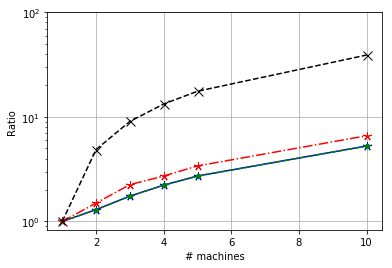

In [10]:
%run ../script/plots.py

fig = plt.figure(1)
# We define a fake subplot that is in fact only the plot.  
axK1 = fig.add_subplot(111)

plt.style.use('ggplot')
#xVals, yVals = get(conn, info="nbCPU, avg(makespan)", workflow="K1", nbNodes=100, netFactor=0.5, models=Scheduling.MODELS)
xVals, yVals = get(conn, info="avg(makespan/max(lp, (sumCPU/nbCPU)))", group=("nbCPU", "nbCPU"), instanceName="LIKE 'K1_100_%'", setParams=" AND networkFactor=0.5", models=Scheduling.MODELS)


for model in Scheduling.MODELS:
    plt.plot(xVals[model], yVals[model], color=COLORS.get(model, "black"), marker=MARKERS[model], linestyle=LINESTYLES[model], label=LABELS[model], markersize=9)

print("\t".join(["nbCPU"]+Scheduling.MODELS))
Xs = xVals[Scheduling.MODELS[0]]
for i in range(len(Xs)):
    print("\t".join([str(Xs[i])] + [str(yVals[model][i]) for model in Scheduling.MODELS]))
table = []
plt.yscale("log")
plt.xlabel("# machines")

plt.ylim(top=100)
plt.ylabel("Ratio")
axK1.tick_params(axis='both', which='major', labelsize=10) # Control label size of legend
plt.grid()
#plt.show()

In [ ]:
%run ../script/plots.py

LIST_WORKFLOWS = ['workflows_20_google_google_1531950079', 'workflows_20_google_google_1531950080', 'workflows_20_google_google_1532023072', 'workflows_20_google_google_1532023073', 'workflows_20_google_google_1532023074', 'workflows_20_google_google_1532023075', 'workflows_20_google_google_1532553962', 'workflows_20_google_google_1532553964']
for workflow in LIST_WORKFLOWS:
    fig = plt.figure(1)
    axWf = fig.add_subplot(111)

    plt.style.use('ggplot')
    xVals, yVals = get(conn, info="avg(sumCPU/nbCPU)", group=("nbCPU", "nbCPU"), instanceName="= '{}'".format(workflow), netFactor=0.5, models=Scheduling.MODELS)

    for model in Scheduling.MODELS:
        plt.plot(xVals[model], yVals[model], color=COLORS.get(model, "black"), marker=MARKERS[model], linestyle=LINESTYLES[model], label=LABELS[model], markersize=9)

    plt.yscale("log")
    plt.xlabel("# machines")

    plt.ylim(top=100)
    plt.ylabel("Ratio")
    axWf.tick_params(axis='both', which='major', labelsize=10) # Control label size of legend
    plt.grid()
    plt.show()

SELECT algo, nbCPU, avg(makespan/max(lp, (sumCPU/nbCPU))) FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance  IN ('workflows_20_google_google_1531950079', 'workflows_20_google_google_1531950080', 'workflows_20_google_google_1532023072', 'workflows_20_google_google_1532023073', 'workflows_20_google_google_1532023074', 'workflows_20_google_google_1532023075', 'workflows_20_google_google_1532553962', 'workflows_20_google_google_1564516472', 'workflows_20_google_google_1564516473', 'workflows_20_google_google_1564516475', 'workflows_20_google_google_1564516476', 'workflows_20_google_google_1564516477', 'workflows_20_google_google_1564516478', 'workflows_20_google_google_1564516479')  AND networkFactor=0.5 AND algo IN ("listScheduling", "listSchedulingMaster", "2P", "listNoCapacity") GROUP BY algo, nbCPU
{'listScheduling': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listNoCapacity': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], '2P': [1.0, 2.0, 3.0, 4.0, 5.0, 

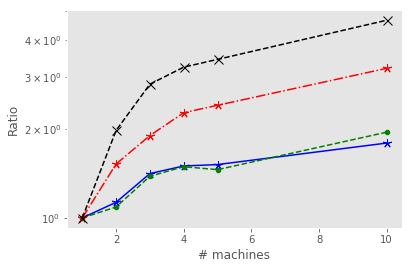

In [27]:
%run ../script/plots.py

#LIST_WORKFLOWS = "IN ('workflows_20_google_google_1531950079', 'workflows_20_google_google_1532023073', 'workflows_20_google_google_1532023074', 'workflows_20_google_google_1532023075', 'workflows_20_google_google_1532553962')"
#LIST_WORKFLOWS = " IN ('workflows_20_google_google_1531950079', 'workflows_20_google_google_1531950080', workflows_20_google_google_1532023072', 'workflows_20_google_google_1532023073','workflows_20_google_google_1532023074', 'workflows_20_google_google_1532023075') "
LIST_WORKFLOWS = " IN ('workflows_20_google_google_1531950079', 'workflows_20_google_google_1531950080', 'workflows_20_google_google_1532023072', 'workflows_20_google_google_1532023073', 'workflows_20_google_google_1532023074', 'workflows_20_google_google_1532023075', 'workflows_20_google_google_1532553962', 'workflows_20_google_google_1564516472', 'workflows_20_google_google_1564516473', 'workflows_20_google_google_1564516475', 'workflows_20_google_google_1564516476', 'workflows_20_google_google_1564516477', 'workflows_20_google_google_1564516478', 'workflows_20_google_google_1564516479')" 
#LIST_WORKFLOWS = " LIKE 'workflows\_20_%' ESCAPE '\\'" 
fig = plt.figure(1)
axWf = fig.add_subplot(111)

plt.style.use('ggplot')
xVals, yVals = get(conn, info="avg(makespan/max(lp, (sumCPU/nbCPU)))", group=("nbCPU", "nbCPU"), instanceName=LIST_WORKFLOWS, setParams=" AND networkFactor=0.5", models=Scheduling.MODELS)

print(xVals, yVals)

for model in Scheduling.MODELS:
    plt.plot(xVals[model], yVals[model], color=COLORS.get(model, "black"), marker=MARKERS[model], linestyle=LINESTYLES[model], label=LABELS[model], markersize=9)

plt.yscale("log")
plt.xlabel("# machines")

#plt.ylim(top=100)
plt.ylabel("Ratio")
axWf.tick_params(axis='both', which='major', labelsize=10) # Control label size of legend
plt.grid()
plt.show("tmp.pdf")

SELECT algo, nbCPU, makespan FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance  LIKE 'workflows_20_google_google_1531950079'  AND networkFactor=0.5 AND algo IN ("listScheduling", "listSchedulingMaster", "2P", "listNoCapacity") GROUP BY algo, nbCPU
{'listScheduling': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listNoCapacity': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], '2P': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listSchedulingMaster': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0]} {'listScheduling': [15965.0, 8210.0, 5690.0, 5067.0, 4663.0, 3957.0], 'listNoCapacity': [15965.0, 18361.0, 20692.0, 18397.0, 16159.0, 15632.0], '2P': [15965.0, 12508.0, 8556.0, 11071.0, 9775.0, 6924.0], 'listSchedulingMaster': [15965.0, 8210.0, 7065.0, 6440.0, 4921.0, 3946.0]}


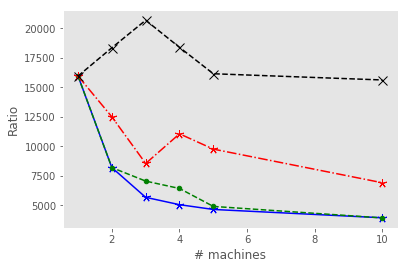

SELECT algo, nbCPU, makespan FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance  LIKE 'workflows_20_google_google_1531950080'  AND networkFactor=0.5 AND algo IN ("listScheduling", "listSchedulingMaster", "2P", "listNoCapacity") GROUP BY algo, nbCPU
{'listScheduling': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listNoCapacity': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], '2P': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listSchedulingMaster': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0]} {'listScheduling': [44502.0, 23215.0, 14845.0, 11145.0, 8919.0, 5093.0], 'listNoCapacity': [44502.0, 37324.0, 26221.0, 23383.0, 25320.0, 14708.0], '2P': [44502.0, 31042.0, 27373.0, 27294.0, 29665.0, 27093.0], 'listSchedulingMaster': [44502.0, 23263.0, 14915.0, 12930.0, 8911.0, 8245.0]}


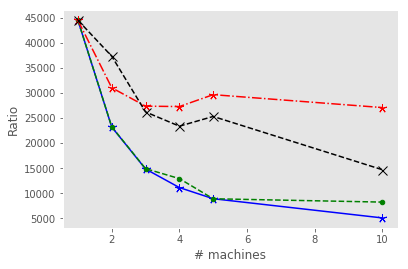

SELECT algo, nbCPU, makespan FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance  LIKE 'workflows_20_google_google_1532023072'  AND networkFactor=0.5 AND algo IN ("listScheduling", "listSchedulingMaster", "2P", "listNoCapacity") GROUP BY algo, nbCPU
{'listScheduling': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listNoCapacity': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], '2P': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listSchedulingMaster': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0]} {'listScheduling': [212.0, 117.0, 99.0, 72.0, 68.0, 57.0], 'listNoCapacity': [212.0, 114.0, 88.0, 79.0, 72.0, 56.0], '2P': [212.0, 114.0, 100.0, 77.0, 70.0, 69.0], 'listSchedulingMaster': [212.0, 121.0, 90.0, 60.0, 54.0, 53.0]}


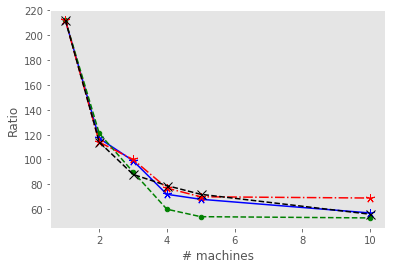

SELECT algo, nbCPU, makespan FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance  LIKE 'workflows_20_google_google_1532023073'  AND networkFactor=0.5 AND algo IN ("listScheduling", "listSchedulingMaster", "2P", "listNoCapacity") GROUP BY algo, nbCPU
{'listScheduling': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listNoCapacity': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], '2P': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listSchedulingMaster': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0]} {'listScheduling': [403.0, 212.0, 178.0, 156.0, 145.0, 129.0], 'listNoCapacity': [403.0, 231.0, 275.0, 216.0, 194.0, 200.0], '2P': [403.0, 261.0, 213.0, 210.0, 195.0, 141.0], 'listSchedulingMaster': [403.0, 206.0, 184.0, 168.0, 156.0, 143.0]}


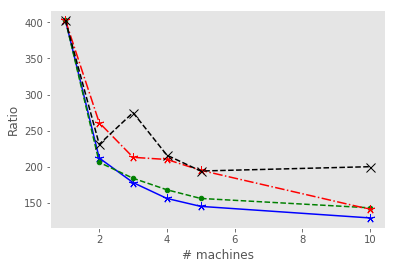

SELECT algo, nbCPU, makespan FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance  LIKE 'workflows_20_google_google_1532023074'  AND networkFactor=0.5 AND algo IN ("listScheduling", "listSchedulingMaster", "2P", "listNoCapacity") GROUP BY algo, nbCPU
{'listScheduling': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listNoCapacity': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], '2P': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listSchedulingMaster': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0]} {'listScheduling': [2105.0, 1142.0, 2130.0, 2231.0, 1893.0, 1973.0], 'listNoCapacity': [2105.0, 4935.0, 5384.0, 5235.0, 5340.0, 4600.0], '2P': [2105.0, 2105.0, 2105.0, 2075.0, 2087.0, 2068.0], 'listSchedulingMaster': [2105.0, 1142.0, 2095.0, 1967.0, 1646.0, 1845.0]}


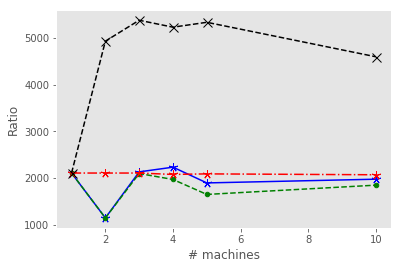

SELECT algo, nbCPU, makespan FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance  LIKE 'workflows_20_google_google_1532023075'  AND networkFactor=0.5 AND algo IN ("listScheduling", "listSchedulingMaster", "2P", "listNoCapacity") GROUP BY algo, nbCPU
{'listScheduling': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listNoCapacity': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], '2P': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listSchedulingMaster': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0]} {'listScheduling': [9757.0, 7532.0, 7816.0, 7444.0, 7397.0, 6388.0], 'listNoCapacity': [9757.0, 17320.0, 15284.0, 13055.0, 12081.0, 8577.0], '2P': [9757.0, 9757.0, 9757.0, 9757.0, 9757.0, 9757.0], 'listSchedulingMaster': [9757.0, 6916.0, 6900.0, 7256.0, 7230.0, 8020.0]}


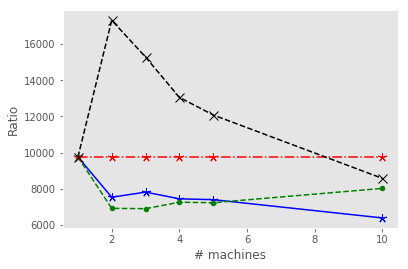

SELECT algo, nbCPU, makespan FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance  LIKE 'workflows_20_google_google_1532553962'  AND networkFactor=0.5 AND algo IN ("listScheduling", "listSchedulingMaster", "2P", "listNoCapacity") GROUP BY algo, nbCPU
{'listScheduling': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listNoCapacity': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], '2P': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listSchedulingMaster': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0]} {'listScheduling': [22705.0, 12421.0, 10301.0, 9152.0, 8150.0, 7220.0], 'listNoCapacity': [22705.0, 21549.0, 25977.0, 24529.0, 21185.0, 19441.0], '2P': [22705.0, 16960.0, 17522.0, 16941.0, 17424.0, 16407.0], 'listSchedulingMaster': [22705.0, 11418.0, 10082.0, 9240.0, 8594.0, 6783.0]}


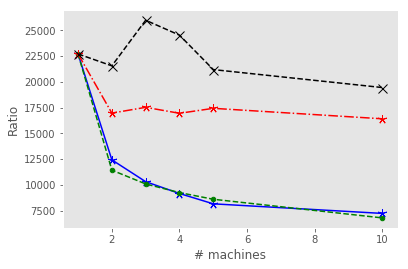

SELECT algo, nbCPU, makespan FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance  LIKE 'workflows_20_google_google_1564516472'  AND networkFactor=0.5 AND algo IN ("listScheduling", "listSchedulingMaster", "2P", "listNoCapacity") GROUP BY algo, nbCPU
{'listScheduling': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listNoCapacity': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], '2P': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listSchedulingMaster': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0]} {'listScheduling': [27064.0, 13541.0, 9063.0, 6824.0, 5469.0, 2769.0], 'listNoCapacity': [27064.0, 13543.0, 9207.0, 6825.0, 5495.0, 2764.0], '2P': [27064.0, 14067.0, 9376.0, 8166.0, 8166.0, 4243.0], 'listSchedulingMaster': [27064.0, 13606.0, 9063.0, 6851.0, 5452.0, 2774.0]}


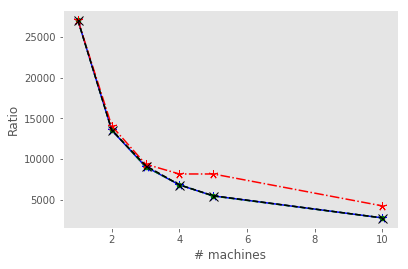

SELECT algo, nbCPU, makespan FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance  LIKE 'workflows_20_google_google_1564516473'  AND networkFactor=0.5 AND algo IN ("listScheduling", "listSchedulingMaster", "2P", "listNoCapacity") GROUP BY algo, nbCPU
{'listScheduling': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listNoCapacity': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], '2P': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listSchedulingMaster': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0]} {'listScheduling': [1519.0, 1106.0, 1015.0, 982.0, 971.0, 956.0], 'listNoCapacity': [1519.0, 1002.0, 976.0, 964.0, 961.0, 959.0], '2P': [1519.0, 1258.0, 1145.0, 1088.0, 1203.0, 1060.0], 'listSchedulingMaster': [1519.0, 953.0, 953.0, 953.0, 953.0, 953.0]}


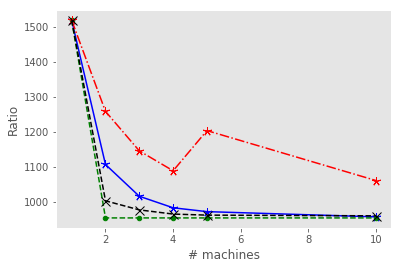

SELECT algo, nbCPU, makespan FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance  LIKE 'workflows_20_google_google_1564516475'  AND networkFactor=0.5 AND algo IN ("listScheduling", "listSchedulingMaster", "2P", "listNoCapacity") GROUP BY algo, nbCPU
{'listScheduling': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listNoCapacity': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], '2P': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listSchedulingMaster': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0]} {'listScheduling': [1127.0, 580.0, 404.0, 356.0, 346.0, 305.0], 'listNoCapacity': [1127.0, 1807.0, 2115.0, 2007.0, 2372.0, 2851.0], '2P': [1127.0, 774.0, 760.0, 830.0, 584.0, 818.0], 'listSchedulingMaster': [1127.0, 579.0, 416.0, 361.0, 346.0, 305.0]}


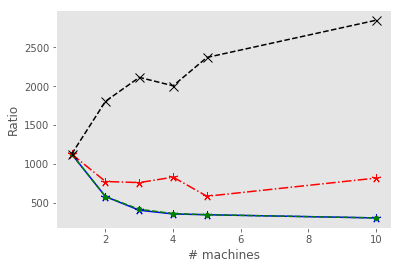

SELECT algo, nbCPU, makespan FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance  LIKE 'workflows_20_google_google_1564516476'  AND networkFactor=0.5 AND algo IN ("listScheduling", "listSchedulingMaster", "2P", "listNoCapacity") GROUP BY algo, nbCPU
{'listScheduling': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listNoCapacity': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], '2P': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listSchedulingMaster': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0]} {'listScheduling': [3035.0, 1529.0, 1031.0, 784.0, 638.0, 606.0], 'listNoCapacity': [3035.0, 1564.0, 1105.0, 1358.0, 709.0, 667.0], '2P': [3035.0, 2652.0, 2438.0, 2118.0, 1398.0, 1060.0], 'listSchedulingMaster': [3035.0, 1529.0, 1023.0, 775.0, 642.0, 610.0]}


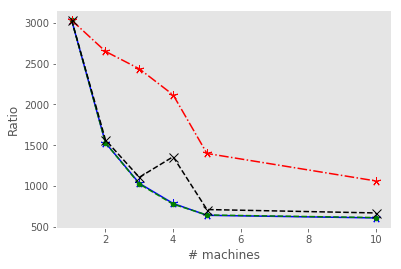

SELECT algo, nbCPU, makespan FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance  LIKE 'workflows_20_google_google_1564516477'  AND networkFactor=0.5 AND algo IN ("listScheduling", "listSchedulingMaster", "2P", "listNoCapacity") GROUP BY algo, nbCPU
{'listScheduling': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listNoCapacity': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], '2P': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listSchedulingMaster': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0]} {'listScheduling': [487.0, 253.0, 180.0, 150.0, 139.0, 97.0], 'listNoCapacity': [487.0, 279.0, 230.0, 246.0, 210.0, 218.0], '2P': [487.0, 391.0, 265.0, 244.0, 242.0, 157.0], 'listSchedulingMaster': [487.0, 247.0, 173.0, 136.0, 112.0, 87.0]}


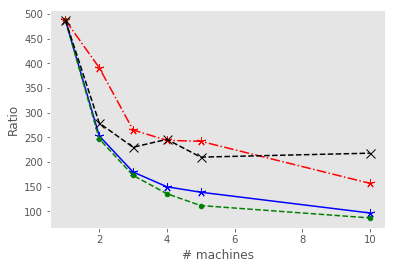

SELECT algo, nbCPU, makespan FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance  LIKE 'workflows_20_google_google_1564516478'  AND networkFactor=0.5 AND algo IN ("listScheduling", "listSchedulingMaster", "2P", "listNoCapacity") GROUP BY algo, nbCPU
{'listScheduling': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listNoCapacity': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], '2P': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listSchedulingMaster': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0]} {'listScheduling': [2150.0, 1540.0, 1433.0, 1285.0, 1268.0, 1090.0], 'listNoCapacity': [2150.0, 2271.0, 2035.0, 2884.0, 2293.0, 2230.0], '2P': [2150.0, 1843.0, 1496.0, 1242.0, 1588.0, 1482.0], 'listSchedulingMaster': [2150.0, 1430.0, 1334.0, 1243.0, 1151.0, 1115.0]}


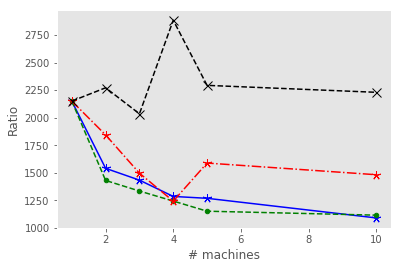

SELECT algo, nbCPU, makespan FROM makespan INNER JOIN instanceInfo ON instanceInfo.instance=makespan.instance WHERE makespan.instance  LIKE 'workflows_20_google_google_1564516479'  AND networkFactor=0.5 AND algo IN ("listScheduling", "listSchedulingMaster", "2P", "listNoCapacity") GROUP BY algo, nbCPU
{'listScheduling': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listNoCapacity': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], '2P': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0], 'listSchedulingMaster': [1.0, 2.0, 3.0, 4.0, 5.0, 10.0]} {'listScheduling': [1453.0, 866.0, 781.0, 665.0, 613.0, 593.0], 'listNoCapacity': [1453.0, 1285.0, 1420.0, 1104.0, 1100.0, 1016.0], '2P': [1453.0, 1212.0, 1067.0, 1034.0, 999.0, 1066.0], 'listSchedulingMaster': [1453.0, 807.0, 756.0, 734.0, 643.0, 678.0]}


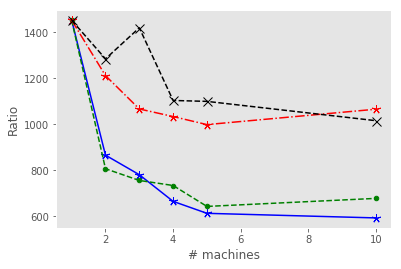

In [26]:
%run ../script/plots.py

for workflow in ['workflows_20_google_google_1531950079', 'workflows_20_google_google_1531950080', 'workflows_20_google_google_1532023072', 'workflows_20_google_google_1532023073', 'workflows_20_google_google_1532023074', 'workflows_20_google_google_1532023075', 'workflows_20_google_google_1532553962', 'workflows_20_google_google_1564516472', 'workflows_20_google_google_1564516473', 'workflows_20_google_google_1564516475', 'workflows_20_google_google_1564516476', 'workflows_20_google_google_1564516477', 'workflows_20_google_google_1564516478', 'workflows_20_google_google_1564516479', ]:
    fig = plt.figure(1)
    axWf = fig.add_subplot(111)

    plt.style.use('ggplot')
    #xVals, yVals = get(conn, info="avg(sumCPU/nbCPU)", group=("nbCPU", "nbCPU"), instanceName=" LIKE '{}'".format(workflow), setParams=" AND networkFactor=0.5", models=Scheduling.MODELS)
    #plt.plot(xVals[Scheduling.MODELS[0]], yVals[Scheduling.MODELS[0]], color=COLORS.get(model, "black"), marker=MARKERS[model], linestyle=LINESTYLES[model], label=LABELS[model], markersize=9)
    #xVals, yVals = get(conn, info="avg(lp)", group=("nbCPU", "nbCPU"), instanceName=" LIKE '{}'".format(workflow), setParams=" AND networkFactor=0.5", models=Scheduling.MODELS)
    #plt.plot(xVals[model], yVals[model], color=COLORS.get(model, "black"), marker=MARKERS[model], linestyle=LINESTYLES[model], label=LABELS[model], markersize=9)
    xVals, yVals = get(conn, info="makespan", group=("nbCPU", "nbCPU"), instanceName=" LIKE '{}'".format(workflow), setParams=" AND networkFactor=0.5", models=Scheduling.MODELS)
    print(xVals, yVals)

    for model in Scheduling.MODELS:
        plt.plot(xVals[model], yVals[model], color=COLORS.get(model, "black"), marker=MARKERS[model], linestyle=LINESTYLES[model], label=LABELS[model], markersize=9)

    #plt.yscale("log")
    plt.xlabel("# machines")

    #plt.ylim(top=100)
    plt.ylabel("Ratio")
    axWf.tick_params(axis='both', which='major', labelsize=10) # Control label size of legend
    plt.grid()
    plt.show("tmp.pdf")

In [ ]:
conn.close()